In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import reader1 as rd
import utilerias as utls
# Llamamos a la función antes de ejecutar el script
utls.eliminar_archivos_registro()

In [2]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'
dataset_train = pd.read_csv(url)
training_set = dataset_train.iloc[:, 1:2].values

In [3]:
DATOS = 'Datos históricos COMI 3ene16-31dic2020 semanal.csv'
cierre = rd.leer_archivo(DATOS).astype(float)
training_set_cierre = np.array(cierre[:int(len(cierre) * 0.7)])

training_set_cierre = np.reshape(training_set_cierre, (training_set_cierre.shape[0], 1))

In [4]:
dataset_train.head()
# print(training_set.shape)
# print(training_set_cierre.shape)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

m_m_s = MinMaxScaler(feature_range=(0,1))
training_set_cierre_scaled = m_m_s.fit_transform(training_set_cierre)

In [6]:
# X_train = []
# y_train = []
# for i in range(60, 2035):
#     X_train.append(training_set_scaled[i-60:i, 0])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [7]:
time_steps = 8
N = len(training_set_cierre_scaled)
X_train_c = []
y_train_c = []
for i in range(time_steps, N):
    X_train_c.append(training_set_cierre_scaled[i-time_steps:i, 0])
    y_train_c.append(training_set_cierre_scaled[i, 0])
X_train_c, y_train_c = np.array(X_train_c), np.array(y_train_c)
X_train_c = np.reshape(X_train_c, (X_train_c.shape[0], X_train_c.shape[1], 1))

In [8]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_train_c.shape)
# print(y_train_c.shape)

In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [10]:
# model = Sequential()
# model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=20,batch_size=32)

In [11]:
red = Sequential()
red.add(LSTM(units=50,return_sequences=True,input_shape=(X_train_c.shape[1], 1)))
red.add(Dropout(0.2))
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50,return_sequences=True))
red.add(Dropout(0.2))
red.add(LSTM(units=50))
red.add(Dropout(0.2))
red.add(Dense(units=1))
red.compile(optimizer='adam',loss='mean_squared_error')
history = red.fit(X_train_c,y_train_c,epochs=50,batch_size=32)

Epoch 1/50
6/6 [==============================] - 5s 10ms/step - loss: 0.4098
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1093
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0799
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0326
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0396
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0265
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0205
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 11/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 12/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0169
Epoch 13/50
6/6 [==============================] - 0s 9ms/step - loss: 0

[0.40977349877357483, 0.10925578325986862, 0.07987861335277557, 0.03258052095770836, 0.03963518887758255, 0.02650648169219494, 0.021430127322673798, 0.020482821390032768, 0.02040085196495056, 0.019065164029598236, 0.013553439639508724, 0.0169476680457592, 0.014300898648798466, 0.012991362251341343, 0.012633449397981167, 0.010835636407136917, 0.012053626589477062, 0.011529093608260155, 0.01118399202823639, 0.011839601211249828, 0.01106799952685833, 0.01154200080782175, 0.012379107996821404, 0.01181674562394619, 0.011698851361870766, 0.01102545764297247, 0.012324634939432144, 0.011430259793996811, 0.010814284905791283, 0.009701876901090145, 0.010238639079034328, 0.011661937460303307, 0.009827140718698502, 0.009965592995285988, 0.010366838425397873, 0.010048800148069859, 0.011005265638232231, 0.008910076692700386, 0.008896516636013985, 0.008811593987047672, 0.010408652946352959, 0.011706187389791012, 0.011207837611436844, 0.009913600981235504, 0.009253179654479027, 0.010011403821408749, 0

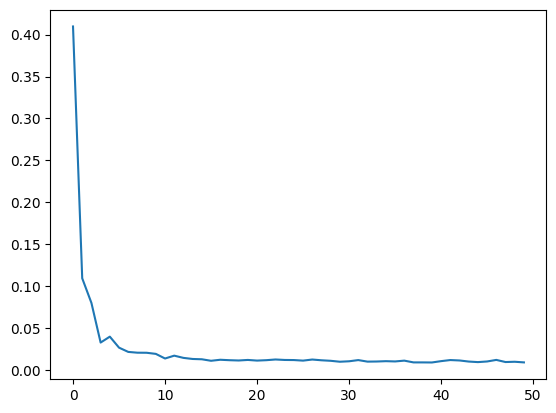

In [21]:
# Obtener la pérdida durante el entrenamiento
losses = history.history['loss']
print(losses)
plt.plot(range(len(losses)),losses)
plt.show()

In [13]:
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/tatatest.csv'
dataset_test = pd.read_csv(url)
real_stock_price = dataset_test.iloc[:, 1:2].values



In [14]:
real_stock_price_cierre = cierre[int(len(cierre) * 0.7):]
real_stock_price_cierre = np.reshape(real_stock_price_cierre, (real_stock_price_cierre.shape[0], 1))

In [15]:
# print(dataset_train['Open'])
# print(dataset_test['Open'])
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# # print(f"dataset_total: {dataset_total}, len: {len(dataset_total)}")
# # print(len(dataset_total) - len(dataset_test) - 60)
# #print(dataset_total)

# inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values#toma los primeros 76 elementos del dataset_total (que son los de entrenamiento)
# print(type(dataset_total))
# #le quita el conjunto de prueba - los ultimos 60 datos de entrenamiento
# # print(f"inputs: {inputs}, len: {len(inputs)}")
# print(f"inputs.shape {inputs.shape}")

# inputs = inputs.reshape(-1,1)
# print(f"inputs.shape {inputs.shape}")
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(60, 76):
#     X_test.append(inputs[i-60:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# predicted_stock_price = model.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [16]:
# dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_steps:].values

inputs_cierre = cierre[len(cierre) - len(real_stock_price_cierre) - time_steps:]
print(len(inputs_cierre))
inputs_cierre = np.array(inputs_cierre).reshape(-1,1)
print(len(inputs_cierre))
print(inputs_cierre.shape)
inputs_cierre = m_m_s.transform(inputs_cierre)
X_test_cierre = []
for i in range(time_steps, len(inputs_cierre)):
    X_test_cierre.append(inputs_cierre[i-time_steps:i, 0])
X_test_cierre = np.array(X_test_cierre)
X_test_cierre = np.reshape(X_test_cierre, (X_test_cierre.shape[0], X_test_cierre.shape[1], 1))
predicted_stock_price_cierre = red.predict(X_test_cierre)
predicted_stock_price_cierre = m_m_s.inverse_transform(predicted_stock_price_cierre)

86
86
(86, 1)
3/3 [==============================] - 1s 3ms/step


In [17]:
# plt.plot(real_stock_price, color = 'black', label = 'TATA Stock Price')
# plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TATA Stock Price')
# plt.title('TATA Stock Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('TATA Stock Price')
# plt.legend()
# plt.show()

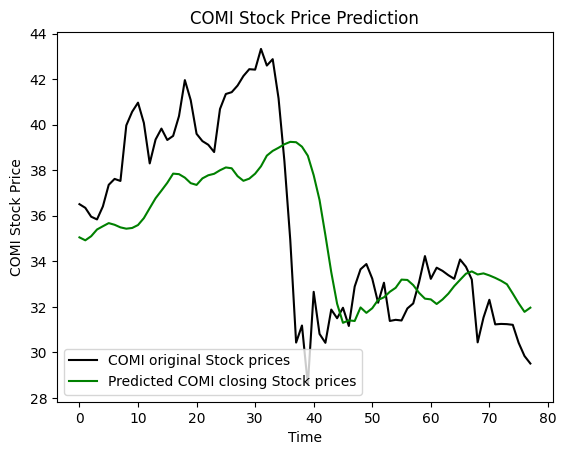

In [18]:
plt.plot(real_stock_price_cierre, color = 'black', label = 'COMI original Stock prices')
plt.plot(predicted_stock_price_cierre, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [19]:
import torch
import torch.nn as nn
criterion = nn.MSELoss()
perdida = criterion(torch.tensor(real_stock_price_cierre),torch.tensor(predicted_stock_price_cierre))
print(perdida)

tensor(9.9085, dtype=torch.float64)
